In [1]:
from __future__ import division, print_function, unicode_literals

In [2]:
MPI_Parallelization=['Active','InActive'][1]
Save_Results=['Active','InActive'][0]

## Inputs

In [3]:

Ng=128; # number of grid points in the DNS setup
Np=16; # number of processor used to run DNS (number of output files in each realization)
"""
the DNS data generated by a pecnil decomposition. For instance for Ng=16, we would have nx=4,ny=4,nz=1. 
Aslo, in this 2d decomposition, we have (rank0,rank3,rank12,rank15)=(top left, top right, bottom left, bottom right)
"""
DNSdata_time_Step=4050#[5550, 5700, 5850, 15450][2]

Case_ID={'Re':90,'Fr':'\infty','TStep':75,'TStep_B':5025,'TStep_E':15000}
Version='25'
read_in_folder='data_DNS_Npr_16/routinecase_V25' # folder that we read in the data from
#read_in_folder1='data_DNS_Npr_16/New folder'
file_names_leading='V'+Version+'_'+'Phy_Vel_VelG.'

## Import Libraries

In [4]:
# Import the required modules
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import contour,contourf
# This makes the plots appear inside the notebook
#%matplotlib inline
import os
import sys 
from scipy.linalg import expm, sinm, cosm
#import odespy, numpy
import time
import pickle
import argparse
import pandas as pd
from decimal import Decimal
# Read HDF5
import h5py
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from IPython.display import HTML
if MPI_Parallelization=='InActive':
     Case_Ids=np.arange(0)
    
else:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    Case_Ids=np.arange(comm.size)

In [5]:
#from matplotlib.pyplot import *

# Changing font to stix; setting specialized math font properties as directly as possible
#from matplotlib import rc
#rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'custom'
#rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:bold'

plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

## Reading/Saving Directory

In [6]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

# N_BVF_str=format_e(Decimal(str(N_BVF))).replace(".", "p")
# tstep_str=format_e(Decimal(str(tstep))).replace(".", "p")

In [7]:
PROJECT_ROOT_DIR = "."
PROJECT_Read_DIR=read_in_folder
PROJECT_SAVE_DIR = "PPResults_Turbulence_"+Version
#makes the directory if it doesn't exist.

if MPI_Parallelization=='InActive':
    if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
        print('Saving directory didn\'t exist, creating now.')
        os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
    else:
        print('Saving directory exists.') 

else:
    if comm.rank == 0:
        if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
            print('Saving directory didn\'t exist, creating now.')
            os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
        else:
            print('Saving directory exists.') 
        
        
        
#a simple defined helper function.
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf',transparent=True) 
def savepng(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.png')    
def save_obj(obj, obj_name):
    with open(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+ obj_name+ '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(obj_name):
    with open(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+ obj_name+'.pkl', 'rb') as f:
        return pickle.load(f)    

Saving directory exists.


## Read in data

In [8]:
# this is from a different DNS data; as a check to resolve the lack of smoothness 
#PROJECT_Read_DIR_1=read_in_folder1

Read_Vel_G_Data=True

U_Phy=np.zeros((Ng,Ng,Ng))+1000
V_Phy=np.zeros_like(U_Phy)+1000
W_Phy=np.zeros_like(U_Phy)+1000

if Read_Vel_G_Data==True:
    dUdx_Phy=np.zeros_like(U_Phy)+1000 
    dUdy_Phy=np.zeros_like(U_Phy)+1000
    dUdz_Phy=np.zeros_like(U_Phy)+1000
    
    dVdx_Phy=np.zeros_like(U_Phy)+1000
    dVdy_Phy=np.zeros_like(U_Phy)+1000
    dVdz_Phy=np.zeros_like(U_Phy)+1000
    
    dWdx_Phy=np.zeros_like(U_Phy)+1000
    dWdy_Phy=np.zeros_like(U_Phy)+1000
    dWdz_Phy=np.zeros_like(U_Phy)+1000
    

row_coordinate=np.zeros_like(U_Phy).astype(int) # row direction
col_coordinate=np.zeros_like(U_Phy).astype(int) # column direction
dep_coordinate=np.zeros_like(U_Phy).astype(int) # depth direction


file_TimeStep=('%06.0f' % Decimal(DNSdata_time_Step))

for b in range(0,Np): # (0,16)
    file_Rank=('%06.0f' % Decimal(b))
    filename=(file_names_leading+file_TimeStep+'.h5.'+file_Rank)
    
    
    print(filename)
    f = h5py.File(PROJECT_Read_DIR+'/'+filename, 'r')
    
    
    i_cell_ID= f['i_cell_ID'] # varies in depth
    j_cell_ID= f['j_cell_ID'] # varies horizontally (from left to right)
    k_cell_ID= f['k_cell_ID'] # varies vertically (from top to bottom)
    
    i_cell_ID_max=np.amax(i_cell_ID )
    i_cell_ID_min=np.amin(i_cell_ID )
    j_cell_ID_max=np.amax(j_cell_ID )
    j_cell_ID_min=np.amin(j_cell_ID )
    k_cell_ID_max=np.amax(k_cell_ID )
    k_cell_ID_min=np.amin(k_cell_ID )
    
    print("i_cell_ID_max=%d,i_cell_ID_min=%d" %(i_cell_ID_max,i_cell_ID_min))
    print("j_cell_ID_max=%d,j_cell_ID_min=%d" %(j_cell_ID_max,j_cell_ID_min))
    print("k_cell_ID_max=%d,k_cell_ID_min=%d" %(k_cell_ID_max,k_cell_ID_min))
    
#     row_coordinate[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=k_cell_ID
#     col_coordinate[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=j_cell_ID
#     dep_coordinate[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=i_cell_ID

    i_min,i_max=int(b//4*Ng/4),int((b//4+1)*Ng/4)
    j_min,j_max=int((b%4)*Ng/4),int(((b%4)+1)*Ng/4)
    
#     j_min,j_max=int(b//4*Ng/4),int((b//4+1)*Ng/4)
#     i_min,i_max=int((b%4)*Ng/4),int(((b%4)+1)*Ng/4)
    
    
    U_Phy[i_min:i_max,j_min:j_max , :]=f['Phy_U'][:]
    V_Phy[i_min:i_max,j_min:j_max , :]=f['Phy_V'][:]
    W_Phy[i_min:i_max,j_min:j_max , :]=f['Phy_W'][:]
    
    if Read_Vel_G_Data==True:
        dUdx_Phy[i_min:i_max,j_min:j_max , :]=f['dUdxG'][:]
        dUdy_Phy[i_min:i_max,j_min:j_max , :]=f['dUdyG'][:]
        dUdz_Phy[i_min:i_max,j_min:j_max , :]=f['dUdzG'][:]
        
        dVdx_Phy[i_min:i_max,j_min:j_max , :]=f['dVdxG'][:]
        dVdy_Phy[i_min:i_max,j_min:j_max , :]=f['dVdyG'][:]
        dVdz_Phy[i_min:i_max,j_min:j_max , :]=f['dVdzG'][:]
        
        dWdx_Phy[i_min:i_max,j_min:j_max , :]=f['dWdxG'][:]
        dWdy_Phy[i_min:i_max,j_min:j_max , :]=f['dWdyG'][:]
        dWdz_Phy[i_min:i_max,j_min:j_max , :]=f['dWdzG'][:]
        
        
        
        
    print("(i_min=%d,i_max=%d):"%(b//4*Ng/4,(b//4+1)*Ng/4))
    print("(j_min=%d,j_max=%d):"%((b%4)*Ng/4,((b%4)+1)*Ng/4))
    print("f['Phy_U'][:].shape=",f['Phy_U'][:].shape)
    print("f['dUdxG'][:].shape=",f['dUdxG'][:].shape)
    f.close()
    

V25_Phy_Vel_VelG.004050.h5.000000
i_cell_ID_max=128,i_cell_ID_min=1
j_cell_ID_max=32,j_cell_ID_min=1
k_cell_ID_max=32,k_cell_ID_min=1
(i_min=0,i_max=32):
(j_min=0,j_max=32):
f['Phy_U'][:].shape= (32, 32, 128)
f['dUdxG'][:].shape= (32, 32, 128)
V25_Phy_Vel_VelG.004050.h5.000001
i_cell_ID_max=128,i_cell_ID_min=1
j_cell_ID_max=64,j_cell_ID_min=33
k_cell_ID_max=32,k_cell_ID_min=1
(i_min=0,i_max=32):
(j_min=32,j_max=64):
f['Phy_U'][:].shape= (32, 32, 128)
f['dUdxG'][:].shape= (32, 32, 128)
V25_Phy_Vel_VelG.004050.h5.000002
i_cell_ID_max=128,i_cell_ID_min=1
j_cell_ID_max=96,j_cell_ID_min=65
k_cell_ID_max=32,k_cell_ID_min=1
(i_min=0,i_max=32):
(j_min=64,j_max=96):
f['Phy_U'][:].shape= (32, 32, 128)
f['dUdxG'][:].shape= (32, 32, 128)
V25_Phy_Vel_VelG.004050.h5.000003
i_cell_ID_max=128,i_cell_ID_min=1
j_cell_ID_max=128,j_cell_ID_min=97
k_cell_ID_max=32,k_cell_ID_min=1
(i_min=0,i_max=32):
(j_min=96,j_max=128):
f['Phy_U'][:].shape= (32, 32, 128)
f['dUdxG'][:].shape= (32, 32, 128)
V25_Phy_Vel_VelG

In [9]:
list_var=[U_Phy,V_Phy,W_Phy]
str_list_var=['U_Phy','V_Phy','W_Phy']
for var,var_name in zip(list_var,str_list_var):
    print(var_name,'\n')
    print("(mean = %f,min = %f,max = %f)"%(var.mean(),var.min(),var.max()))
    print('\n')

U_Phy 

(mean = -0.000000,min = -3.263950,max = 3.953695)


V_Phy 

(mean = -0.000000,min = -3.584116,max = 3.739558)


W_Phy 

(mean = 0.000000,min = -3.516961,max = 3.517226)




In [10]:
if Read_Vel_G_Data==True:    
    list_var=[dUdx_Phy,dUdy_Phy,dUdz_Phy,dVdx_Phy,dVdy_Phy,dVdz_Phy,dWdx_Phy,dWdy_Phy,dWdz_Phy]
    str_list_var=['dUdx_Phy','dUdy_Phy','dUdz_Phy','dVdx_Phy','dVdy_Phy','dVdz_Phy','dWdx_Phy','dWdy_Phy','dWdz_Phy']
    for var,var_name in zip(list_var,str_list_var):
        print(var_name,'\n')
        print("(mean = %f,min = %f,max = %f)"%(var.mean(),var.min(),var.max()))

        print('\n')

dUdx_Phy 

(mean = 0.000000,min = -20.571899,max = 16.351901)


dUdy_Phy 

(mean = -0.000000,min = -36.312411,max = 33.361560)


dUdz_Phy 

(mean = -0.000000,min = -27.305689,max = 30.908267)


dVdx_Phy 

(mean = -0.000000,min = -26.829636,max = 28.074953)


dVdy_Phy 

(mean = 0.000000,min = -16.829817,max = 16.264607)


dVdz_Phy 

(mean = -0.000000,min = -28.405948,max = 40.621226)


dWdx_Phy 

(mean = 0.000000,min = -38.280280,max = 38.249805)


dWdy_Phy 

(mean = 0.000000,min = -33.778821,max = 35.621547)


dWdz_Phy 

(mean = -0.000000,min = -16.698402,max = 15.098273)




## Utility Functions for post-processing

In [11]:
def replaceZeroes(data):
  min_nonzero = np.min(data[np.nonzero(data)])
  data[data == 0] = min_nonzero
  return data

In [12]:
import pyUSID as usid

print('-------------------------')
usid.hdf_utils.print_tree(h5py.File(PROJECT_Read_DIR+'/'+filename, 'r'))
print('-------------------------')

ModuleNotFoundError: No module named 'pyUSID'

## Plotting to check if the cordinates are as expected

In [ ]:
fig,ax=plt.subplots(nrows=1, ncols=3,figsize=(15,5))
i_d_min,i_d_max=1,2
j_d_min,j_d_max=0,128
k_d_min,k_d_max=0,128

plt.colorbar(ax[0].imshow(U_Phy[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[0])
ax[0].set_title("U component")
plt.colorbar(ax[1].imshow(V_Phy[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[1])
ax[1].set_title("V component")
plt.colorbar(ax[2].imshow(W_Phy[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[2])
ax[2].set_title("W component")
# ax[0].grid()
pass

In [ ]:
if Read_Vel_G_Data==True:    
    list_var=[dUdx_Phy,dUdy_Phy,dUdz_Phy,dVdx_Phy,dVdy_Phy,dVdz_Phy,dWdx_Phy,dWdy_Phy,dWdz_Phy]
    str_list_var=['dUdx_Phy','dUdy_Phy','dUdz_Phy','dVdx_Phy','dVdy_Phy','dVdz_Phy','dWdx_Phy','dWdy_Phy','dWdz_Phy']

    fig,axes=plt.subplots(nrows=3, ncols=3,figsize=(20,25))
    i_d_min,i_d_max=3,4
    j_d_min,j_d_max=0,128
    k_d_min,k_d_max=0,128
    
    
    
    for i,var,var_name in zip(range(9),list_var,str_list_var):
        plt.colorbar(axes[i//3][i%3].imshow(var[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=axes[i//3][i%3]) 
        axes[i//3][i%3].set_title(var_name)


In [ ]:
%%capture
from mpl_toolkits.axes_grid1 import make_axes_locatable
steps=Ng
sim=U_Phy
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# div = make_axes_locatable(ax)
# cax = div.append_axes('right', '5%', '5%')

im = plt.imshow(sim[0])
cb = fig.colorbar(im)
tx = ax.set_title('Frame 0')
def updatefig(j):
    im.set_array(sim[j])
    im.set_clim(np.min(sim), np.max(sim))
    tx.set_text('Frame {0}'.format(j))
    return [im]

ani = animation.FuncAnimation(fig, updatefig, frames=range(steps), 
                              interval=1000, blit=False);

In [ ]:
%%time

HTML(ani.to_jshtml())

In [ ]:
%%capture
from mpl_toolkits.axes_grid1 import make_axes_locatable
steps=Ng
sim=dUdx_Phy
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# div = make_axes_locatable(ax)
# cax = div.append_axes('right', '5%', '5%')

im = plt.imshow(sim[0])
cb = fig.colorbar(im)
tx = ax.set_title('dUdx_Phy Frame 0')
def updatefig(j):
    im.set_array(sim[j])
    im.set_clim(np.min(sim), np.max(sim))
    tx.set_text('dUdx_Phy Frame {0}'.format(j))
    return [im]

ani = animation.FuncAnimation(fig, updatefig, frames=range(steps), 
                              interval=1000, blit=False);

In [ ]:
%%time

HTML(ani.to_jshtml())

# Plot Q-R

### compute Q-R

In [ ]:
def Q_R_Calculator_slow(A_2d):
    A2=np.matmul(A_2d,A_2d)
    A3=np.matmul(A_2d,A2)
    

    
    Q=(-1/2)*np.trace(A2)
    R=(-1/3)*np.trace(A3)
    
    S=(1/2)*(A_2d+A_2d.T)
    SijSij=np.sum(S*S) # rotation
    
    Rot=(1/2)*(A_2d-A_2d.T)
    
    RijRij=np.sum(Rot*Rot)
                     
    return Q,R,SijSij,RijRij


def Q_R_Calculator(A11,A12,A13,A21,A22,A23,A31,A32,A33,Fast=True):
    
    if Fast==False:
        ng=A11.shape[0]
        R_loop=np.zeros_like(A11)
        Q_loop=np.zeros_like(A11)
        SijSij_loop=np.zeros_like(A11)
        RijRij_loop=np.zeros_like(A11)
        
        for i in range(0,ng):
            for j in range(0,ng):
                for k in range(0,ng):
                    A_2d_t=np.array([
                        [A11[i,j,k],A12[i,j,k],A13[i,j,k]],
                        [A21[i,j,k],A22[i,j,k],A23[i,j,k]],
                        [A31[i,j,k],A32[i,j,k],A33[i,j,k]]
                    ])
                    Q_loop[i,j,k],R_loop[i,j,k],SijSij_loop[i,j,k],RijRij_loop[i,j,k]=Q_R_Calculator_slow(A_2d_t)
        
        return Q_loop,R_loop,SijSij_loop,RijRij_loop
    
    else:
        
        # initialize the outputs
        trace_A2=np.zeros_like(A11)
        trace_A3=np.zeros_like(A11)
        S_ijS_ij=np.zeros_like(A11)
        R_ijR_ij=np.zeros_like(A11)
        
        # compute trace of A2=A^2=np.matmul(A,A)
        trace_A2= A11**2 + A22**2 + A33**2 + 2*(A12*A21 + A13*A31 +A23*A32)

        # compute trace of A3=A^3=np.matmul(A,A2)
        trace_A3= A11*(A11**2 + A12*A21 + A13*A31) +\
            A22*(A22**2 + A12*A21 + A23*A32) +\
                A33*(A33**2 + A13*A31 +A23*A32)+\
                    A21*(A11*A12 + A12*A22 +A13*A32) +\
                        A31*(A11*A13 + A12*A23 +A13*A33) +\
                            A12*(A11*A21 +A21*A22 + A23*A31) +\
                                A32*(A13*A21+ A22*A23 + A23*A33) +\
                                    A13*(A11*A31+ A21*A32 + A31*A33) +\
                                        A23*(A12*A31+ A22*A32 + A32*A33)

        S_ijS_ij= ((1/2)*(A11+A11))**2+((1/2)*(A22+A22))**2+((1/2)*(A33+A33))**2+\
        2*((1/2)*(A12+A21))**2+2*((1/2)*(A13+A31))**2+2*((1/2)*(A23+A32))**2 

        R_ijR_ij= 2*((1/2)*(A12-A21))**2+2*((1/2)*(A13-A31))**2+2*((1/2)*(A23-A32))**2 


        return (-1/2)*trace_A2,(-1/3)*trace_A3,S_ijS_ij,R_ijR_ij  #Q,R,,S_ijS_ij

#### Compute Q,R using loops (not efficinet)

In [ ]:
%%time
Q_loop,R_loop,SijSij_loop,RijRij_loop=Q_R_Calculator(dUdx_Phy,dUdy_Phy,dUdz_Phy,\
                                                     dVdx_Phy,dVdy_Phy,dVdz_Phy,\
                                                     dWdx_Phy,dWdy_Phy,dWdz_Phy,Fast=False)

In [ ]:
Q_loop.shape,R_loop.shape,SijSij_loop.shape,RijRij_loop.shape

#### Compute Q,R with broadcasting (efficinet)

In [ ]:
%%time
Q,R,S_ijS_ij,R_ijR_ij=Q_R_Calculator(dUdx_Phy,dUdy_Phy,dUdz_Phy,\
                                                     dVdx_Phy,dVdy_Phy,dVdz_Phy,\
                                                     dWdx_Phy,dWdy_Phy,dWdz_Phy,Fast=True)

In [ ]:
Q.shape,R.shape,S_ijS_ij.shape,R_ijR_ij.shape

In [ ]:
52.9/0.946

In [ ]:
SijSij_mean=np.mean(S_ijS_ij)
RijRij_mean=np.mean(R_ijR_ij)
print(r"|S_{ij}S_{ij}|=%.16f"%SijSij_mean)
print(r"|R_{ij}R_{ij}|=%.16f"%RijRij_mean) 

##### make sure that both implemetations yield the same results

In [ ]:
np.allclose(Q,Q_loop),np.allclose(R,R_loop),np.allclose(S_ijS_ij,SijSij_loop),np.allclose(R_ijR_ij,RijRij_loop)

#### compute 2d pdfs

In [ ]:
def bin_array(X,Y,binwidth):
    
    bins_1=np.arange(np.amin([np.amin(X),np.amin(Y)]), \
                                           np.amax([np.amax(X),np.amax(Y)]) + binwidth, binwidth)
    return bins_1

def plot_Q_R(Q_t,R_t,SijSij_mean_t,\
             binwidth=100//10,\
            lev=np.array([0.001,1e-1*0.001,1e-2*0.001,1e-3*0.001,1e-4*0.001])[::-1],\
            lev_colors=('r', 'green', 'blue', 'cyan', 'magenta')):
    """ takes Q, R and SijSij_mean tesnors which have shape of (Ng,Ng,Ng) """
    
    ### bin intervals
    bins_1=bin_array(R_t.ravel(), Q_t.ravel(),binwidth=binwidth)
    ### histogram
    H, xedges_R, yedges_Q= np.histogram2d(R_t.ravel(), Q_t.ravel(), density=True,bins=bins_1)
    xedges_C_R= xedges_R[:-1] + (xedges_R[1] - xedges_R[0])/2   # convert bin edges to centers
    yedges_C_Q = yedges_Q[:-1] + (yedges_Q[1] - yedges_Q[0])/2   # convert bin edges to centers
    X_M, Y_M = np.meshgrid(xedges_C_R, yedges_C_Q)
    print("xedges_R.shape",xedges_R.shape)
    H = H.T  # Let each row list bins with common y range.
    
    fig_R_Q = plt.figure(figsize=(20, 10))

    camp='viridis'#'hot'
    #lev=[]

    
    contours =contour(X_M/SijSij_mean_t**(3/2), Y_M/SijSij_mean_t,H,levels=lev,\
                      origin='lower', colors=lev_colors,linewidths=2)
    plt.clabel(contours, inline=True,fmt = '%.9f', fontsize=14)

    plt.colorbar(contours);

    Rx=np.arange(-10,10,0.1)
    plt.plot(Rx,-((27/4)*Rx**2)**(1/3),'k-',label='$Q=-(27R^2/4)^{1/3}$')
    plt.legend(fontsize=25)

    plt.xlabel(r"$R/(S_{ij}S_{ij})^{(3/2)}}$",fontsize=25)
    plt.ylabel(r"$Q/S_{ij}S_{ij}$",fontsize=25)
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.grid()
    # plt.title('$\Gamma=%.2f,\ \Delta t=%.3f, \ t_{f}=%.3f, \ N_{bvf}=%.3f , \ Pr=%.3f  , \ N_{Cases}=%d$'\
    #           %(Gamma,tstep,Final_time,N_BVF,Pr,len(System_Data.keys())),fontsize=20)
    plt.show()


In [ ]:
plot_Q_R(Q,R,SijSij_mean)

# Plot PDF of velocity components

In [ ]:
def plot_PDF_Velocity(u,v,w,\
                      str_list_var=['U_Phy','V_Phy','W_Phy'],\
                      num_bins = int(1500)):
    list_var=[u,v,w]
    fig,axes=plt.subplots(nrows=1, ncols=3,figsize=(20,5))     

    fontsize_N=15
    for i,var,var_name in zip(range(9),list_var,str_list_var):


        p, x = np.histogram((var.ravel()-np.mean(var.ravel()))/np.std(var.ravel()), density=True,bins=num_bins) 
        x = x[:-1] + (x[1] - x[0])/2
        y=np.log10(replaceZeroes(p))

        axes[i].plot(x, y,'b',lw=2,label=var_name)

        axes[i].set_xlim(-6, 6)
        axes[i].set_ylim(-5, 0)

        axes[i].set_xlabel("Normalized "+var_name,fontsize=fontsize_N)
        axes[i].set_ylabel('log10(PDF)',fontsize=fontsize_N)

        axes[i].grid(True)

        xx =np.linspace(-5, 5, 1000)
        axes[i].plot(xx, np.log10(stats.norm.pdf(xx, 0, 1)),'r--',label="Guassian")
        axes[i].legend(fontsize=fontsize_N)
        
        pass


In [ ]:
plot_PDF_Velocity(U_Phy,V_Phy,W_Phy)

# PDF of velocity gradient components

In [ ]:
def plot_PDF_VelocityGrad(A11,A12,A13,A21,A22,A23,A31,A32,A33,\
                         str_list_var=['dUdx_Phy','dUdy_Phy','dUdz_Phy','dVdx_Phy','dVdy_Phy','dVdz_Phy','dWdx_Phy','dWdy_Phy','dWdz_Phy'],\
                         num_bins = int(1500)):
    
    list_var=[A11,A12,A13,A21,A22,A23,A31,A32,A33]
    
    fig,axes=plt.subplots(nrows=3, ncols=3,figsize=(20,25))     
    
    fontsize_N=15
    for i,var,var_name in zip(range(9),list_var,str_list_var):       
        
        p, x = np.histogram((var.ravel()-np.mean(var.ravel()))/np.std(var.ravel()), density=True,bins=num_bins) 
        x = x[:-1] + (x[1] - x[0])/2
        y=np.log10(replaceZeroes(p))
        
        axes[i//3][i%3].plot(x, y,'b',lw=2,label=var_name)
        
        axes[i//3][i%3].set_xlim(-10, 10)
        axes[i//3][i%3].set_ylim(-5, 0)
        
        axes[i//3][i%3].set_xlabel("Normalized "+var_name,fontsize=fontsize_N)
        axes[i//3][i%3].set_ylabel('log10(PDF)',fontsize=fontsize_N)
        
        axes[i//3][i%3].grid(True)
        
        xx =np.linspace(-5, 5, 1000)
        axes[i//3][i%3].plot(xx, np.log10(stats.norm.pdf(xx, 0, 1)),'r--',label="Guassian")
        axes[i//3][i%3].legend(fontsize=fontsize_N)

In [ ]:
plot_PDF_VelocityGrad(dUdx_Phy,dUdy_Phy,dUdz_Phy,dVdx_Phy,dVdy_Phy,dVdz_Phy,dWdx_Phy,dWdy_Phy,dWdz_Phy)

# Check Fourier and wave number map

In [ ]:
# From DNS code [-N/2+1,N/2]
del_kx=del_ky=del_kz=1
Nx=Ny=Nz=Ng
kxD=np.zeros(Nx)
kyD=np.zeros(Ny)
kzD=np.zeros(Nz)
for i in range(Nx):
    kxD[i]=i*del_kx
    if (i>Nx/2):
        kxD[i]=(i-Nx)*del_kx
    
kxD

In [ ]:
kxx=np.fft.fftfreq(Ng, d=(1/Ng));# from [-N/2,N/2-1]
print("max(kxx)=",max(kxx))
kxx, np.allclose(kxD,kxx),kxD.shape,kxx.shape,np.max(kxD-kxx)

If A = fft(a, n), then A[0] contains the zero-frequency term (the sum of the signal), which is always purely real for real inputs. Then A[1:n/2] contains the positive-frequency terms, and A[n/2+1:] contains the negative-frequency terms, in order of decreasingly negative frequency.
https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft


There are many ways to define the DFT, varying in the sign of the exponent, normalization, etc. In this implementation, the DFT is defined as

$A_k =  \sum_{m=0}^{n-1} a_m \exp\left\{-2\pi i{mk \over n}\right\} \qquad k = 0,\ldots,n-1$.

The DFT is in general defined for complex inputs and outputs, and a single-frequency component at linear frequency f is represented by a complex exponential a_m = \exp\{2\pi i\,f m\Delta t\}, where \Delta t is the sampling interval.

The values in the result follow so-called “standard” order: If A = fft(a, n), then A[0] contains the zero-frequency term (the sum of the signal), which is always purely real for real inputs. Then A[1:n/2] contains the positive-frequency terms, and A[n/2+1:] contains the negative-frequency terms, in order of decreasingly negative frequency. For an even number of input points, A[n/2] represents both positive and negative Nyquist frequency, and is also purely real for real input. For an odd number of input points, A[(n-1)/2] contains the largest positive frequency, while A[(n+1)/2] contains the largest negative frequency. The routine np.fft.fftfreq(n) returns an array giving the frequencies of corresponding elements in the output. 

In [ ]:
kxx[0] , kxx[1:Nx//2] , kxx[Nx//2:]

In [ ]:
kxD[0] , kxD[1:Nx//2] , kxD[Nx//2:]

#### difference between fftn and rfftn

In [ ]:
np.fft.fftn(U_Phy).shape,np.fft.rfftn(U_Phy).shape

### make sure that inverse fft can recover the physical signal

In [ ]:
np.allclose(U_Phy,np.fft.ifftn(np.fft.fftn(U_Phy)))

In [ ]:
np.allclose(U_Phy,np.fft.irfftn(np.fft.rfftn(U_Phy)))

### Perform Filtering

In [13]:
def filtering_Gaus(Phy_Sig,factor_I_L=[1/2,1/4][0],\
                   Coef_Gauss_Filter=0.5,\
                   kk=np.fft.fftfreq (Ng , 1./ Ng).astype( int ),\
                   eta=1.46/55.8):

    cut_off_freq=1*(0.1)*(factor_I_L)/(eta)
    
    print("eta= ",eta, "cut-off freq. = ",cut_off_freq)
    
    K = np.array ( np.meshgrid ( kk , kk , kk ,indexing ='ij') , dtype = int )
    K2 = np.sum( K*K , 0, dtype = int )
    K2_m=np.where (K2 == 0, 1, K2 ) . astype ( float )
    
    Gaussina_LPF=np.exp(-Coef_Gauss_Filter*K2_m/(cut_off_freq**2))
    
    Spec_Sig=np.fft.fftn(Phy_Sig)
    filtered_Phy_Sig=np.real(np.fft.ifftn( np.multiply(Gaussina_LPF,Spec_Sig) )) # np.max(np.imag(filtered_U_Phy)),np.min(np.imag(filtered_U_Phy))
    
    MSE_filtered=np.mean((filtered_Phy_Sig-Phy_Sig)**2)
    
    return filtered_Phy_Sig,MSE_filtered

In [14]:
def plot_filtered_Signal(Coef_Gauss_Filter,filtered_Sig,Orig_Sig,i_d_min=5,i_d_max=6,print_MSE=True):

    fig,ax=plt.subplots(nrows=1, ncols=2,figsize=(10,5))
    
    j_d_min,j_d_max=0,128
    k_d_min,k_d_max=0,128
    
    if print_MSE==True:
        MSE=np.mean((filtered_Sig-Orig_Sig)**2)
        print("Coef_Gauss_Filter = ", Coef_Gauss_Filter," ,  mean squared error = ", MSE)
        
    plt.colorbar(ax[0].imshow(Orig_Sig[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[0])
    ax[0].set_title("Original Signal")
    plt.colorbar(ax[1].imshow(filtered_Sig[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[1])
    ax[1].set_title("Filtered Signal with \n Gauss_Coef %.3f and MSE %.4f" %(Coef_Gauss_Filter,MSE))
    #pass

    

   

In [15]:
def plot2d_PDF_filtered_Signal(Coef_Gauss_Filter,filtered_Sig,Orig_Sig,i_d_min=5,i_d_max=6,print_MSE=True,\
                               num_bins = int(1500)):

    fig,ax=plt.subplots(nrows=1, ncols=3,figsize=(20,5))
    
    j_d_min,j_d_max=0,128
    k_d_min,k_d_max=0,128
    fontsize_N=15
    if print_MSE==True:
        MSE=np.mean((filtered_Sig-Orig_Sig)**2)
        print("Coef_Gauss_Filter = ", Coef_Gauss_Filter," ,  mean squared error = ", MSE)
        
    plt.colorbar(ax[0].imshow(Orig_Sig[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[0])
    ax[0].set_title("Original Signal")
    plt.colorbar(ax[1].imshow(filtered_Sig[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[1])
    ax[1].set_title("Filtered Signal with \n Gauss_Coef %.3f and MSE %.4f" %(Coef_Gauss_Filter,MSE))
    
    # PDF of Original and Filtered Physical signals
    var=Orig_Sig
    p, x = np.histogram((var.ravel()-np.mean(var.ravel()))/np.std(var.ravel()), density=True,bins=num_bins) 
    x = x[:-1] + (x[1] - x[0])/2
    y=np.log10(replaceZeroes(p))
    ax[2].plot(x, y,'b',lw=2,label='Orig_Sig')    
        
    var=filtered_Sig
    p, x = np.histogram((var.ravel()-np.mean(var.ravel()))/np.std(var.ravel()), density=True,bins=num_bins) 
    x = x[:-1] + (x[1] - x[0])/2
    y=np.log10(replaceZeroes(p))
    ax[2].plot(x, y,'g',lw=2,label='filtered_Sig')        
    
    ax[2].set_xlim(-6, 6)
    ax[2].set_ylim(-5, 0)

    ax[2].set_xlabel("Normalized "+'Signal',fontsize=fontsize_N)
    ax[2].set_ylabel('log10(PDF)',fontsize=fontsize_N)

    ax[2].grid(True)

    xx =np.linspace(-5, 5, 1000)
    ax[2].plot(xx, np.log10(stats.norm.pdf(xx, 0, 1)),'r--',label="Guassian")
    ax[2].legend(fontsize=fontsize_N)
    #pass

In [16]:
# from sklearn.metrics import mean_squared_error
# mean_squared_error(filtered_Sig.ravel(),Phy_Sig.ravel())

eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.5  ,  mean squared error =  0.3250299277971207


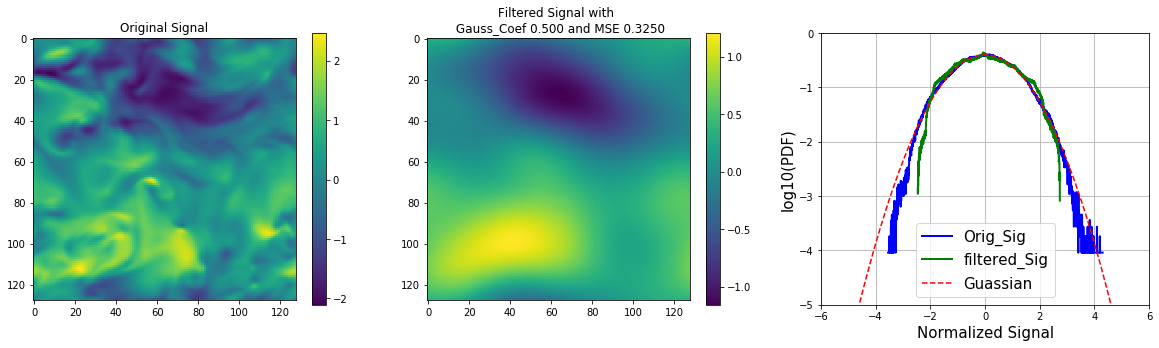

In [17]:
Phy_Sig=U_Phy
Coef_Gauss_Filter=1/2
factor_I_L=[1/2,1/4][0]
filtered_Sig,MSE_filtered=filtering_Gaus(Phy_Sig,factor_I_L=factor_I_L,\
                   Coef_Gauss_Filter=Coef_Gauss_Filter)
plot2d_PDF_filtered_Signal(Coef_Gauss_Filter,filtered_Sig,Orig_Sig=Phy_Sig,i_d_min=3,i_d_max=4)

eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.5  ,  mean squared error =  0.2945175921871296


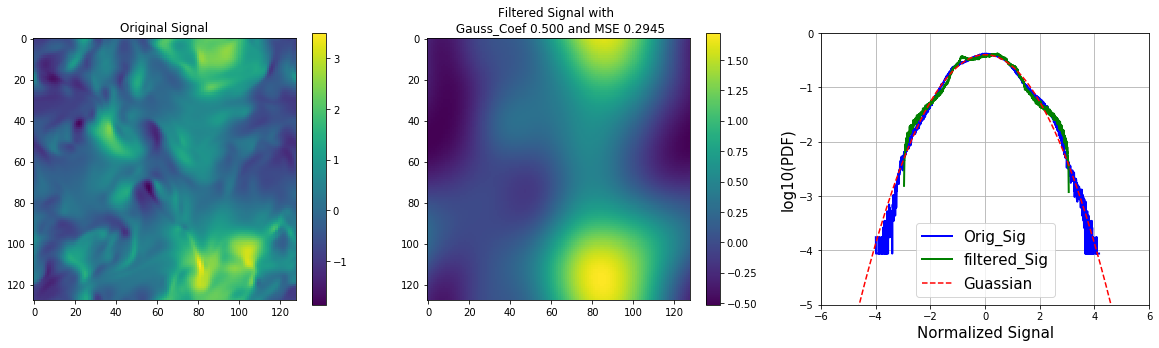

In [18]:
Phy_Sig=V_Phy
Coef_Gauss_Filter=1/2
factor_I_L=[1/2,1/4][0]
filtered_Sig,MSE_filtered=filtering_Gaus(Phy_Sig,factor_I_L=factor_I_L,\
                   Coef_Gauss_Filter=Coef_Gauss_Filter)
plot2d_PDF_filtered_Signal(Coef_Gauss_Filter,filtered_Sig,Orig_Sig=Phy_Sig,i_d_min=3,i_d_max=4)

eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.5  ,  mean squared error =  0.3465517751806535


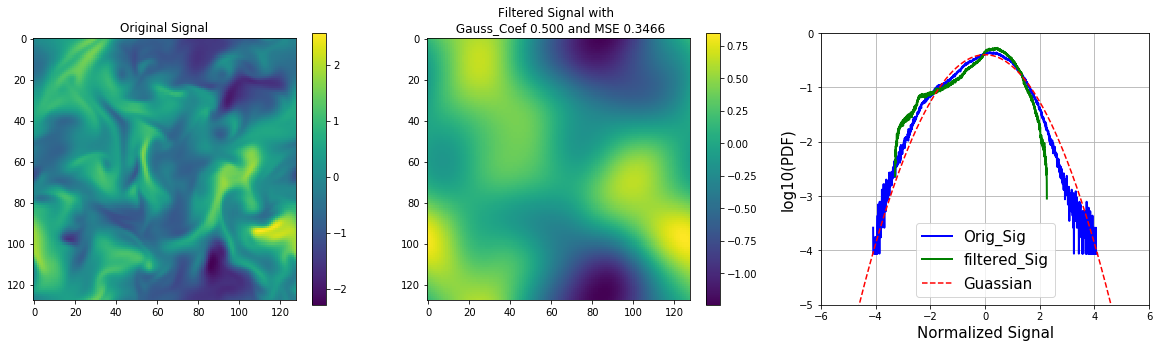

In [49]:
Phy_Sig=W_Phy
Coef_Gauss_Filter=1/2
factor_I_L=[1/2,1/4][0]
filtered_Sig,MSE_filtered=filtering_Gaus(Phy_Sig,factor_I_L=factor_I_L,\
                   Coef_Gauss_Filter=Coef_Gauss_Filter)
plot2d_PDF_filtered_Signal(Coef_Gauss_Filter,filtered_Sig,Orig_Sig=Phy_Sig,i_d_min=3,i_d_max=4)

eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.5  ,  mean squared error =  0.3424066425151511


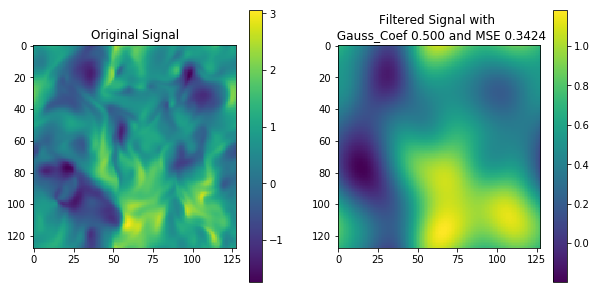

In [50]:
Phy_Sig=V_Phy
Coef_Gauss_Filter=1/2
filtered_Sig,MSE_filtered=filtering_Gaus(Phy_Sig,factor_I_L=[1/2,1/4][0],\
                   Coef_Gauss_Filter=Coef_Gauss_Filter)
plot_filtered_Signal(Coef_Gauss_Filter,filtered_Sig,Orig_Sig=Phy_Sig,i_d_min=3,i_d_max=4)

eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  1  ,  mean squared error =  0.4680498896272018
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.5  ,  mean squared error =  0.3438421307887608
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.25  ,  mean squared error =  0.23963704149732773
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.1  ,  mean squared error =  0.13021994284344776
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.01  ,  mean squared error =  0.011627928008761093
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.002  ,  mean squared error =  0.0009815094982913402


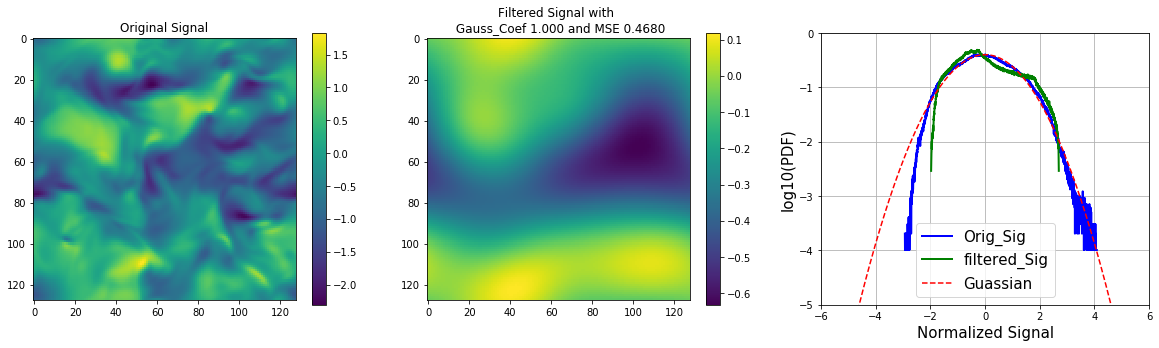

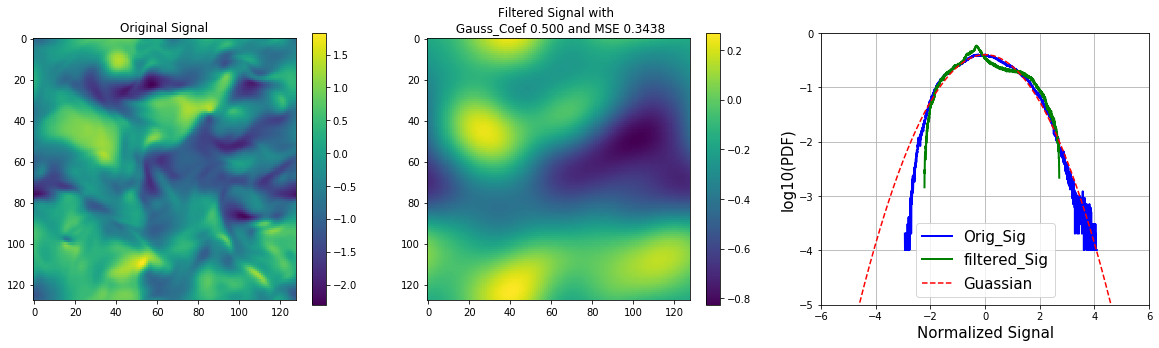

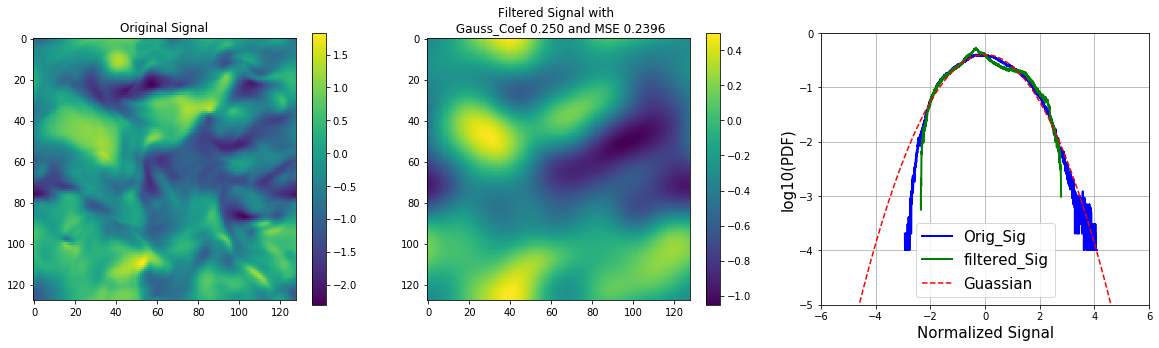

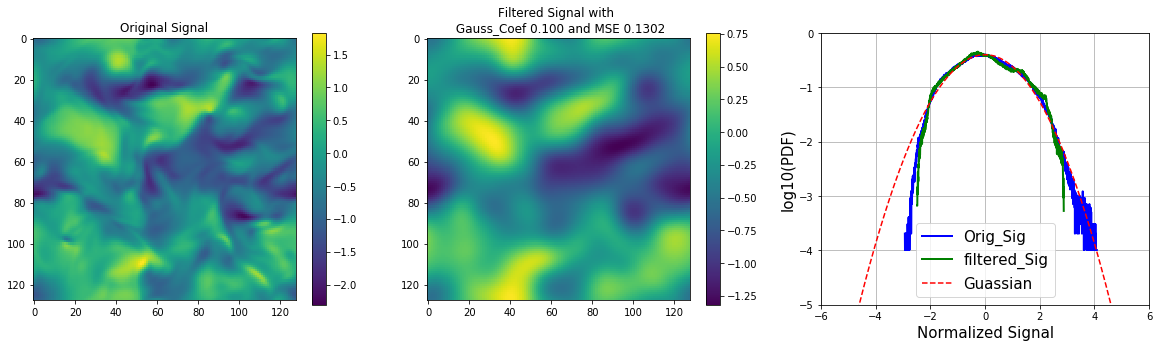

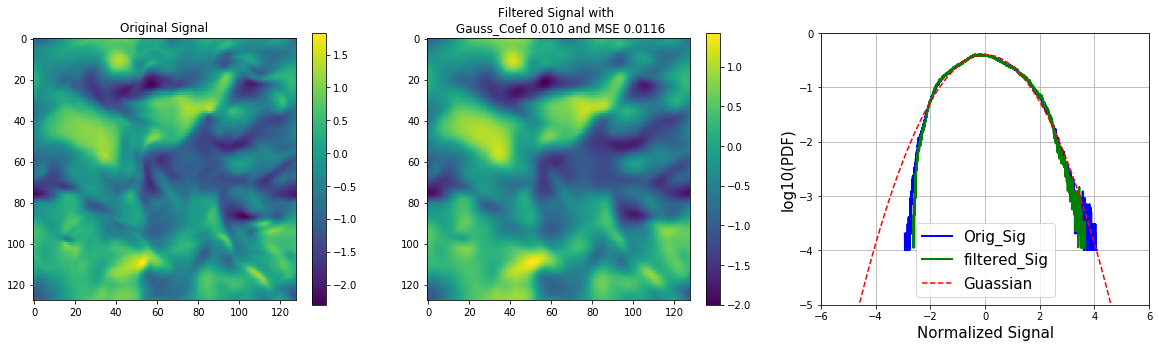

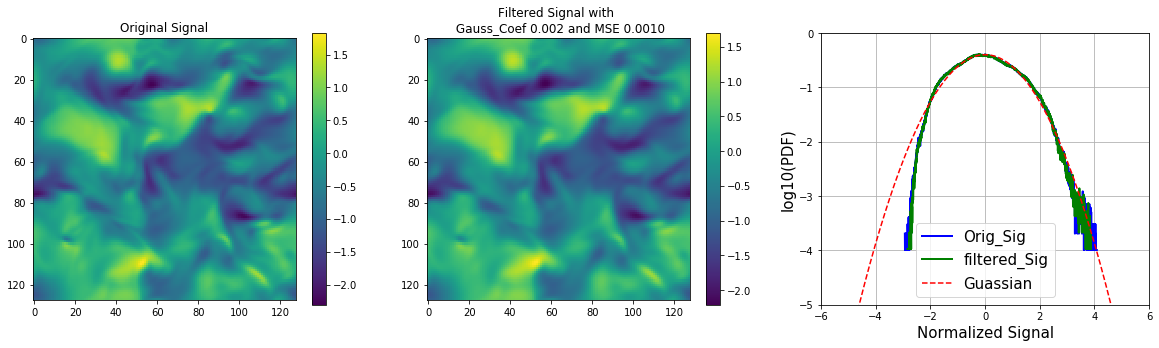

In [51]:
Phy_Sig=U_Phy

for Gauss_Coeff in [1,1/2,1/4,1/10,1/100,1/500]:
    
    filtered_Sig,_=filtering_Gaus(Phy_Sig,factor_I_L=[1/2,1/4][0],\
                   Coef_Gauss_Filter=Gauss_Coeff)
    plot2d_PDF_filtered_Signal(Gauss_Coeff,filtered_Sig,Orig_Sig=Phy_Sig,i_d_min=3,i_d_max=4)
    

eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  1  ,  mean squared error =  0.4647435741875142
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.5  ,  mean squared error =  0.3424066425151511
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.25  ,  mean squared error =  0.23824255415014048
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.1  ,  mean squared error =  0.12879272383295245
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.01  ,  mean squared error =  0.0113658854238988
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.002  ,  mean squared error =  0.0009498606959132725


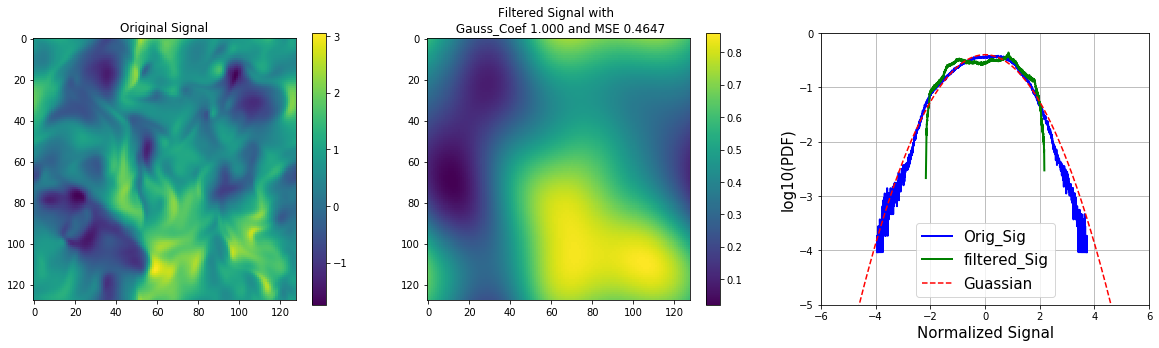

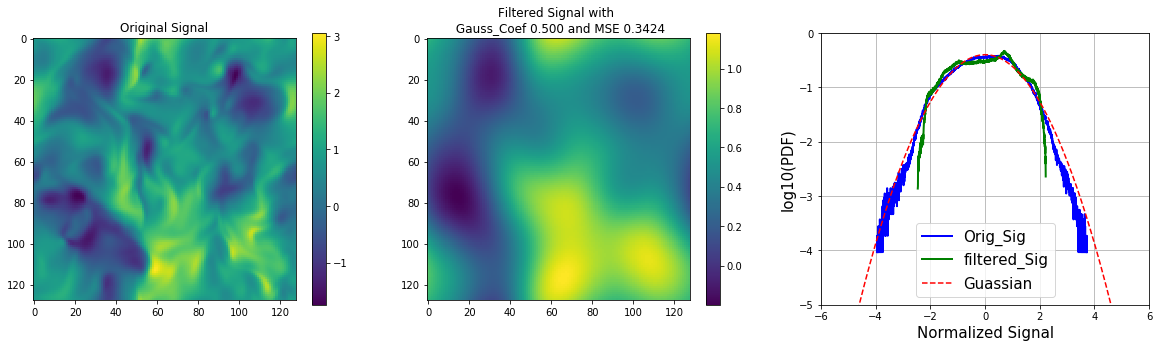

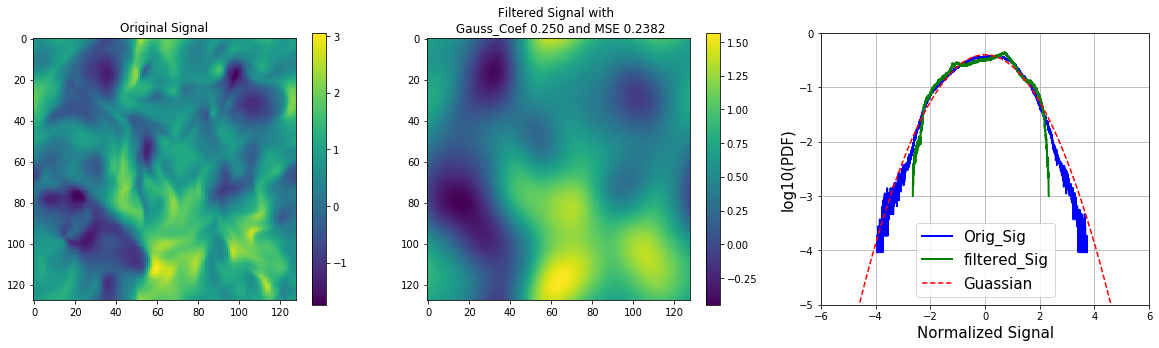

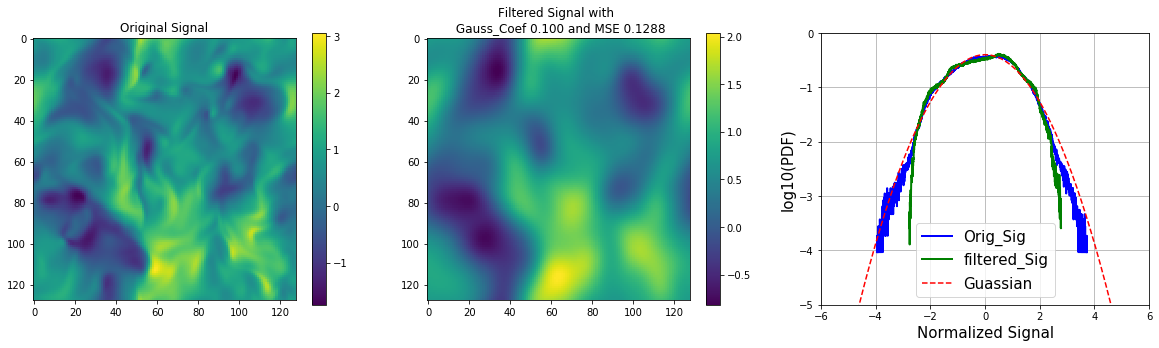

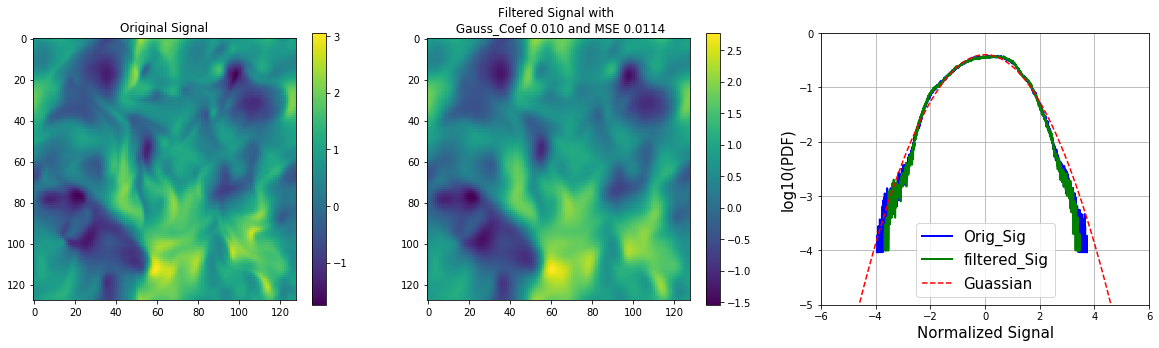

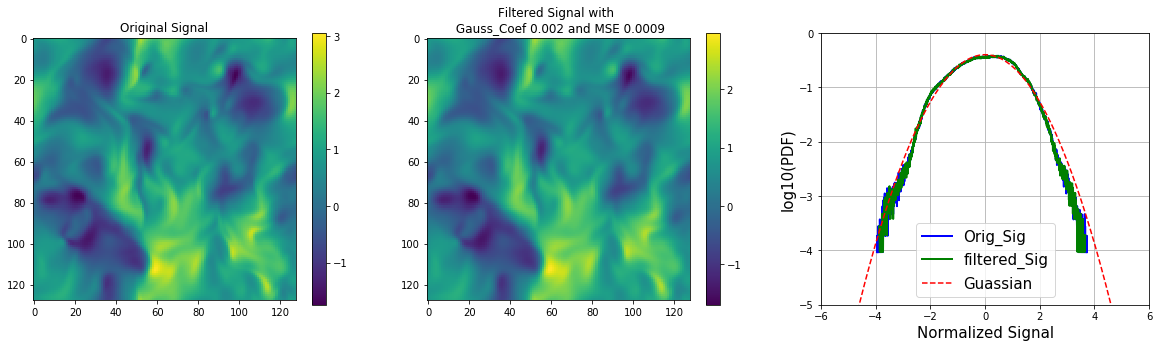

In [52]:
Phy_Sig=V_Phy

for Gauss_Coeff in [1,1/2,1/4,1/10,1/100,1/500]:
    
    filtered_Sig,_=filtering_Gaus(Phy_Sig,factor_I_L=[1/2,1/4][0],\
                   Coef_Gauss_Filter=Gauss_Coeff)
    plot2d_PDF_filtered_Signal(Gauss_Coeff,filtered_Sig,Orig_Sig=Phy_Sig,i_d_min=3,i_d_max=4)
    

eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  1  ,  mean squared error =  0.45669641942259626
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.5  ,  mean squared error =  0.3465517751806535
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.25  ,  mean squared error =  0.24148088566867948
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.1  ,  mean squared error =  0.12985093173672005
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.01  ,  mean squared error =  0.011623889655008216
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
Coef_Gauss_Filter =  0.002  ,  mean squared error =  0.0009695360559229501


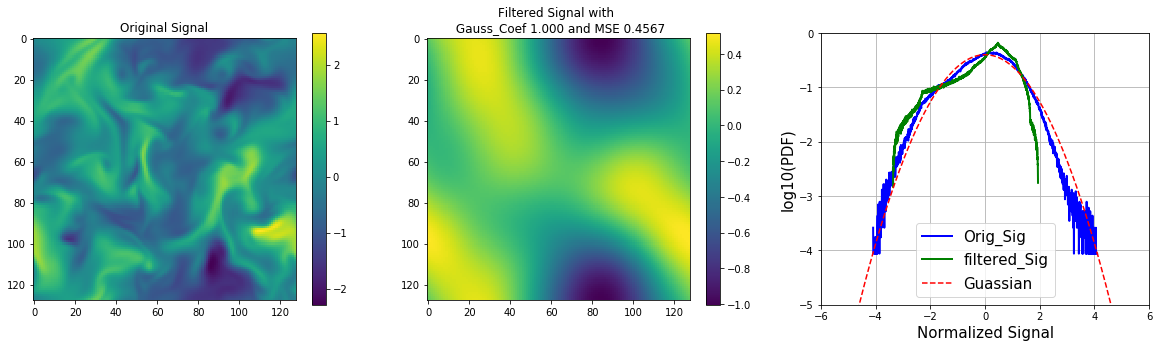

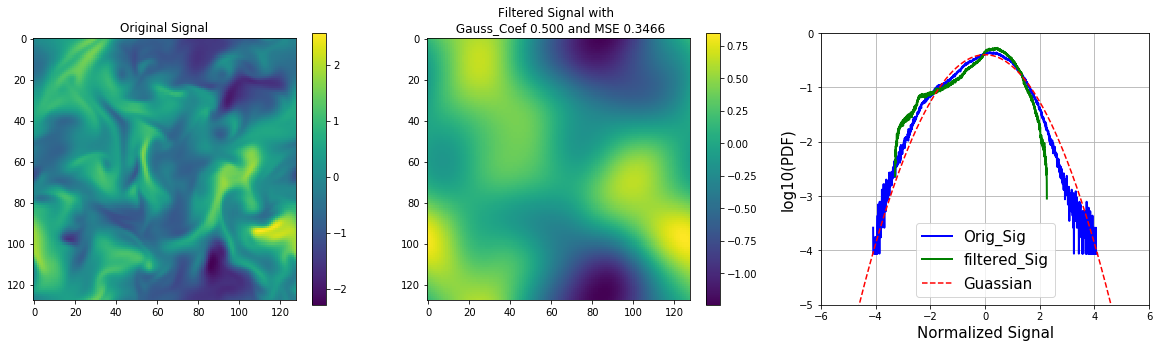

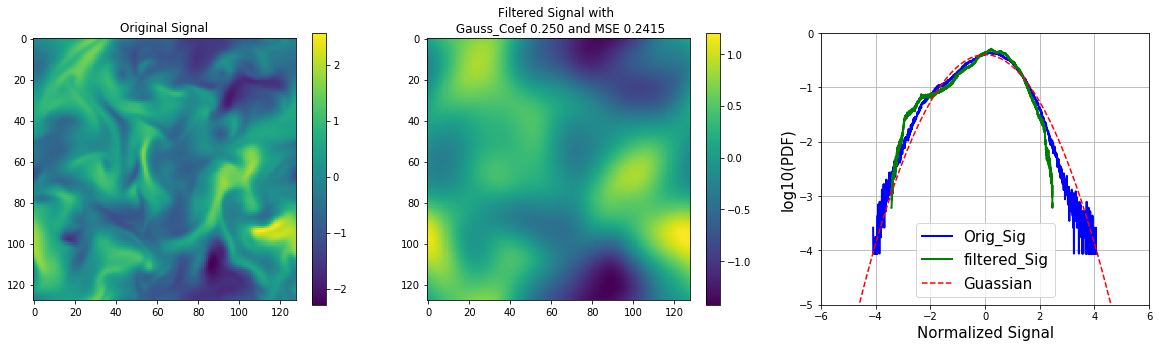

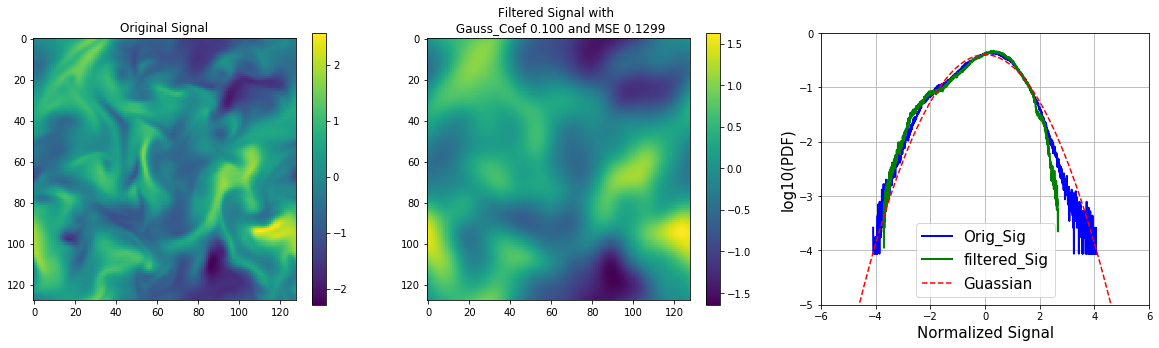

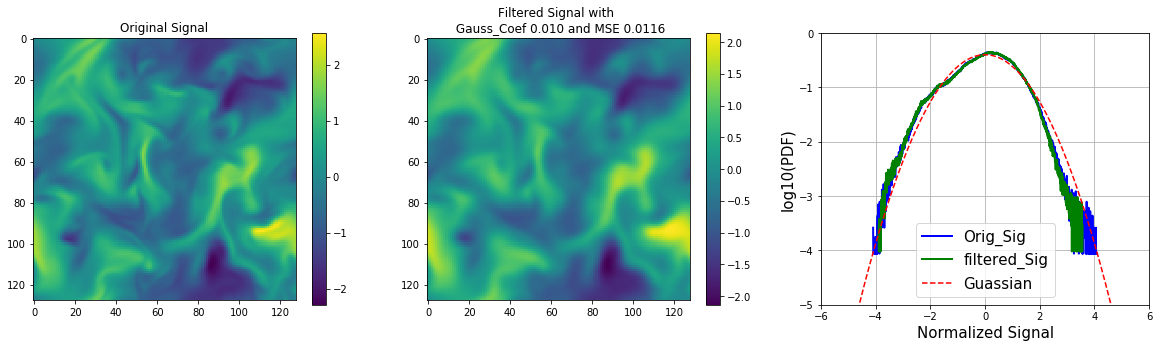

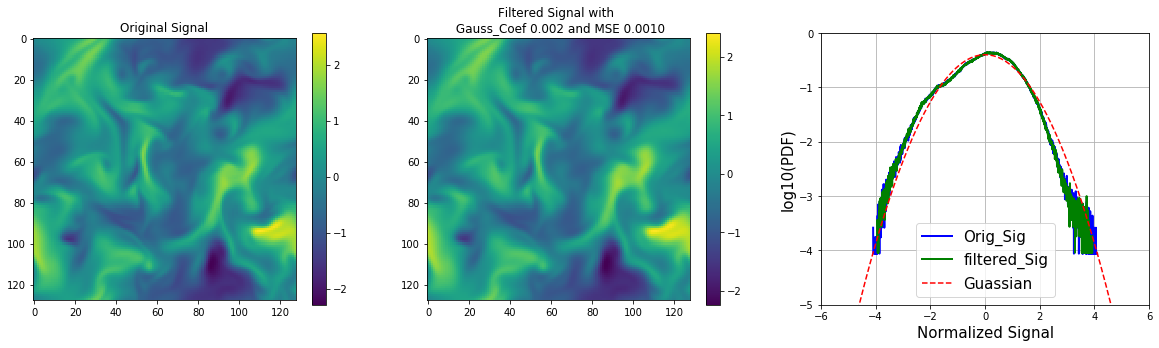

In [53]:
Phy_Sig=W_Phy

for Gauss_Coeff in [1,1/2,1/4,1/10,1/100,1/500]:
    
    filtered_Sig,_=filtering_Gaus(Phy_Sig,factor_I_L=[1/2,1/4][0],\
                   Coef_Gauss_Filter=Gauss_Coeff)
    plot2d_PDF_filtered_Signal(Gauss_Coeff,filtered_Sig,Orig_Sig=Phy_Sig,i_d_min=3,i_d_max=4)
    

### perform spectral derivative

#### Exact DNS code methodology

In [55]:
def FFT_derivative(Phy_Vel,direction='x',kk=np.fft.fftfreq (Ng , 1./ Ng),Fast=True):
    
    pre=np.fft.fftn(Phy_Vel)
    post=np.zeros_like(pre)
    output=np.zeros_like(Phy_Vel)
    
    if Fast==False:
        
        if direction=='x':
            for i in range(Phy_Vel.shape[0]):
                for j in range(Phy_Vel.shape[1]):       
                    for k in range(Phy_Vel.shape[2]):           
                        post[k,j,i] = pre[k,j,i]*1.0j*kk[i] # no matter if you put kx or ky or kz
        if direction=='y':
            for i in range(Phy_Vel.shape[0]):
                for j in range(Phy_Vel.shape[1]):       
                    for k in range(Phy_Vel.shape[2]):           
                        post[k,j,i] = pre[k,j,i]*1.0j*kk[j] # no matter if you put kx or ky or kz
        if direction=='z':
            for i in range(Phy_Vel.shape[0]):
                for j in range(Phy_Vel.shape[1]):       
                    for k in range(Phy_Vel.shape[2]):           
                        post[k,j,i] = pre[k,j,i]*1.0j*kk[k] # no matter if you put kx or ky or kz
        output=np.real(np.fft.ifftn(post))
        return output
    
    else:
        
        kxmesh,kymesh,kzmesh=np.meshgrid(kk,kk,kk,indexing='ij');
    
        if direction=='x':
            output=np.real(np.fft.ifftn(1.0j *np.multiply(pre,kzmesh)))       
        elif direction=='y':
            output=np.real(np.fft.ifftn(1.0j *np.multiply(pre,kymesh)))  
        else : #direction=='z'
            output=np.real(np.fft.ifftn(1.0j *np.multiply(pre,kxmesh)))  
        return output
        

#### compute spectral derivatives; slow method

In [56]:
%%time
list_var=[dUdx_Phy,dUdy_Phy,dUdz_Phy,dVdx_Phy,dVdy_Phy,dVdz_Phy,dWdx_Phy,dWdy_Phy,dWdz_Phy]
str_list_var=['dUdx_Phy','dUdy_Phy','dUdz_Phy','dVdx_Phy','dVdy_Phy','dVdz_Phy','dWdx_Phy','dWdy_Phy','dWdz_Phy']
directions=3*['x','y','z']
list_var_Vel=[U_Phy,U_Phy,U_Phy,V_Phy,V_Phy,V_Phy,W_Phy,W_Phy,W_Phy]
for var,var_name,deriv_dir,var_vel in zip(list_var,str_list_var,directions,list_var_Vel):
    der=FFT_derivative(var_vel,direction=deriv_dir,Fast=False)
    print("all close between true and FFT computed ",var_name,'\n')
    print(np.allclose(var,der))
    print("MSE = ",np.mean((var-der)**2))    
    print('\n')

all close between true and FFT computed  dUdx_Phy 

True
MSE =  4.073550657329997e-29


all close between true and FFT computed  dUdy_Phy 

True
MSE =  9.176474571714693e-29


all close between true and FFT computed  dUdz_Phy 

True
MSE =  1.3413150065401266e-28


all close between true and FFT computed  dVdx_Phy 

True
MSE =  4.976167995960667e-29


all close between true and FFT computed  dVdy_Phy 

True
MSE =  8.65853644302718e-29


all close between true and FFT computed  dVdz_Phy 

True
MSE =  1.2977301723319835e-28


all close between true and FFT computed  dWdx_Phy 

True
MSE =  4.6072683580362244e-29


all close between true and FFT computed  dWdy_Phy 

True
MSE =  8.468605901822885e-29


all close between true and FFT computed  dWdz_Phy 

True
MSE =  1.1160298697577975e-28


Wall time: 16.6 s


#### compute spectral derivatives; fast method

In [57]:
%%time
list_var=[dUdx_Phy,dUdy_Phy,dUdz_Phy,dVdx_Phy,dVdy_Phy,dVdz_Phy,dWdx_Phy,dWdy_Phy,dWdz_Phy]
str_list_var=['dUdx_Phy','dUdy_Phy','dUdz_Phy','dVdx_Phy','dVdy_Phy','dVdz_Phy','dWdx_Phy','dWdy_Phy','dWdz_Phy']
directions=3*['x','y','z']
list_var_Vel=[U_Phy,U_Phy,U_Phy,V_Phy,V_Phy,V_Phy,W_Phy,W_Phy,W_Phy]
for var,var_name,deriv_dir,var_vel in zip(list_var,str_list_var,directions,list_var_Vel):
    der=FFT_derivative(var_vel,direction=deriv_dir,Fast=True)
    print("all close between true and FFT computed ",var_name,'\n')
    print(np.allclose(var,der))
    print("MSE = ",np.mean((var-der)**2))
    print('\n')

all close between true and FFT computed  dUdx_Phy 

True
MSE =  4.073550657329997e-29


all close between true and FFT computed  dUdy_Phy 

True
MSE =  9.176474571714693e-29


all close between true and FFT computed  dUdz_Phy 

True
MSE =  1.3413150065401266e-28


all close between true and FFT computed  dVdx_Phy 

True
MSE =  4.976167995960667e-29


all close between true and FFT computed  dVdy_Phy 

True
MSE =  8.65853644302718e-29


all close between true and FFT computed  dVdz_Phy 

True
MSE =  1.2977301723319835e-28


all close between true and FFT computed  dWdx_Phy 

True
MSE =  4.6072683580362244e-29


all close between true and FFT computed  dWdy_Phy 

True
MSE =  8.468605901822885e-29


all close between true and FFT computed  dWdz_Phy 

True
MSE =  1.1160298697577975e-28


Wall time: 5.39 s


### Compute Energy Spectra

In [58]:
# lx=ly=lz=2.0*np.pi
# del_k = min(2.0*np.pi/lx,2.0*np.pi/ly,2.0*np.pi/lz)
# del_k
# np.mean(U_Phy*U_Phy),np.mean(V_Phy*V_Phy),np.mean(W_Phy*W_Phy),np.sqrt((1.0079229286621583+ 0.9511537810520678+ 0.7940762991238077)/3)

In [59]:
print("2k=<u**2+v**2+w**2>=",np.mean((U_Phy**2+V_Phy**2+W_Phy**2).ravel()))

np.mean(U_Phy**2),np.mean(V_Phy**2),np.mean(W_Phy**2)


2k=<u**2+v**2+w**2>= 2.7531530088380363


(1.0079229286621583, 0.9511537810520678, 0.7940762991238077)

In [60]:
def Energy_Spectrum(u,v,w,kk=np.fft.fftfreq (Ng , 1./ Ng),Fast=True):
    
    ## This part is always constant
    K = np.array ( np.meshgrid ( kk , kk , kk ,indexing ='ij') , dtype = int )
    K2 = np.sum( K*K , 0, dtype = int )
    nshell_GridP = (((2.0*np.sqrt(K2))+1)//2).astype(int)
    ##
    #####################
    Energy_GridP=np.zeros_like(u)
    Energy_k=np.zeros(u.shape[0])
    
    u_hat=np.fft.fftn(u)
    v_hat=np.fft.fftn(v)
    w_hat=np.fft.fftn(w)
    
    if Fast==True:
        
        Energy_GridP=1/2*( np.real(u_hat*np.conj(u_hat)) +\
                          np.real(v_hat*np.conj(v_hat)) + \
                          np.real(w_hat*np.conj(w_hat)) )/(u.shape[0])**6
        for Nshell in np.unique(nshell_GridP.ravel()):
            Energy_k[Nshell]= np.sum(Energy_GridP[nshell_GridP==Nshell])
        return Energy_k
    
    else:                
       
        for i in range(u.shape[0]):
            for j in range(u.shape[1]):
                for k in range(u.shape[2]):

                    Rmag = kk[i]**2 + kk[j]**2 + kk[k]**2
                    nshell = int((int(2.0*np.sqrt(Rmag))+1)/2)
                    #if (nshell<=Ng):
                    

                    e11=np.real(u_hat[k,j,i]*np.conj(u_hat[k,j,i]))
                    e22=np.real(v_hat[k,j,i]*np.conj(v_hat[k,j,i]))
                    e33=np.real(w_hat[k,j,i]*np.conj(w_hat[k,j,i]))

                    Energy_k[nshell] = Energy_k[nshell] + (1/2)*(e11 + e22 + e33)
        return Energy_k/(u.shape[0])**6

In [61]:
%%time
Energy_Spectra=Energy_Spectrum(U_Phy,V_Phy,W_Phy)

Wall time: 1.03 s


In [62]:
%%time
Energy_Spectra_slow=Energy_Spectrum(U_Phy,V_Phy,W_Phy,Fast=False)

Wall time: 18.6 s


In [63]:
np.allclose(Energy_Spectra,Energy_Spectra_slow)

True

Tot Ene =  1.3765765044190175 (2*TotEn)= 2.753153008838035
 u_prime=sqrt(2*k/3) =  0.9579758189081174
From Pure data >> 2k=<u**2+v**2+w**2>= 2.7531530088380363


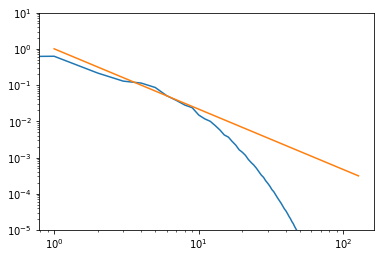

In [64]:
xx=np.arange(Ng)
plt.plot(xx,Energy_Spectra)
plt.plot(xx[1:],(xx[1:]**(-5/3)))
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-5,10])
print("Tot Ene = ", np.sum(Energy_Spectra),"(2*TotEn)=",(2*np.sum(Energy_Spectra)))
print(" u_prime=sqrt(2*k/3) = " , np.sqrt((2*np.sum(Energy_Spectra))/3 ))
print("From Pure data >> 2k=<u**2+v**2+w**2>=",np.mean((U_Phy**2+V_Phy**2+W_Phy**2).ravel()))
pass

In [66]:
Rmag =3* max(np.fft.fftfreq (Ng , 1./ Ng))**2
nshell = int((int(2.0*np.sqrt(Rmag))+1)/2)
nshell

109

## R-Q of filtered Velocity field

In [67]:
dic_filtered={}
Coef_Gauss_Filter=1/200
factor_I_L=[1/2,1/4][0]
for var,var_name in zip([U_Phy,V_Phy,W_Phy],['U_Phy','V_Phy','W_Phy']):  
    filtered_Sig,_=filtering_Gaus(var,factor_I_L=factor_I_L,\
                   Coef_Gauss_Filter=Coef_Gauss_Filter)
    dic_filtered[var_name+'_'+'filtered']=filtered_Sig
#dic_filtered    

eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891
eta=  0.026164874551971327 cut-off freq. =  1.9109589041095891


In [68]:
str_list_var=['dUdx_Phy','dUdy_Phy','dUdz_Phy','dVdx_Phy','dVdy_Phy','dVdz_Phy','dWdx_Phy','dWdy_Phy','dWdz_Phy']
directions=3*['x','y','z']
list_var_Vel_name=[bb for a in [3*[item] for item in list(dic_filtered.keys())] for bb in a ]  
for var_name,deriv_dir,var_vel_name in zip(str_list_var,directions,list_var_Vel_name):
    var_vel=dic_filtered[var_vel_name]
    der=FFT_derivative(var_vel,direction=deriv_dir,Fast=True)
    dic_filtered[var_name + '_' + 'filtered']=der
#dic_filtered    

In [69]:
Q_f,R_f,S_ijS_ij_f,R_ijR_ij_f=Q_R_Calculator(dic_filtered['dUdx_Phy' + '_' + 'filtered'],\
                                             dic_filtered['dUdy_Phy' + '_' + 'filtered'],\
                                             dic_filtered['dUdz_Phy' + '_' + 'filtered'],\
                                             dic_filtered['dVdx_Phy' + '_' + 'filtered'],\
                                             dic_filtered['dVdy_Phy' + '_' + 'filtered'],\
                                             dic_filtered['dVdz_Phy' + '_' + 'filtered'],\
                                             dic_filtered['dWdx_Phy' + '_' + 'filtered'],\
                                             dic_filtered['dWdy_Phy' + '_' + 'filtered'],\
                                             dic_filtered['dWdz_Phy' + '_' + 'filtered'])


In [70]:
SijSij_mean_f=np.mean(S_ijS_ij_f)
RijRij_mean_f=np.mean(R_ijR_ij_f)
print(r"filtered |S_{ij}S_{ij}|=%.16f"%SijSij_mean_f)
print(r"filtered |R_{ij}R_{ij}|=%.16f"%RijRij_mean_f) 

filtered |S_{ij}S_{ij}|=20.4722522096263972
filtered |R_{ij}R_{ij}|=20.4722522096263795


In [71]:
Q_f.shape,R_f.shape

((128, 128, 128), (128, 128, 128))

In [72]:
bin_array(R_f.ravel(), Q_f.ravel(),binwidth=1/10)

array([-1459.67117787, -1459.57117787, -1459.47117787, ...,
         802.52882212,   802.62882212,   802.72882212])

xedges_R.shape (756,)


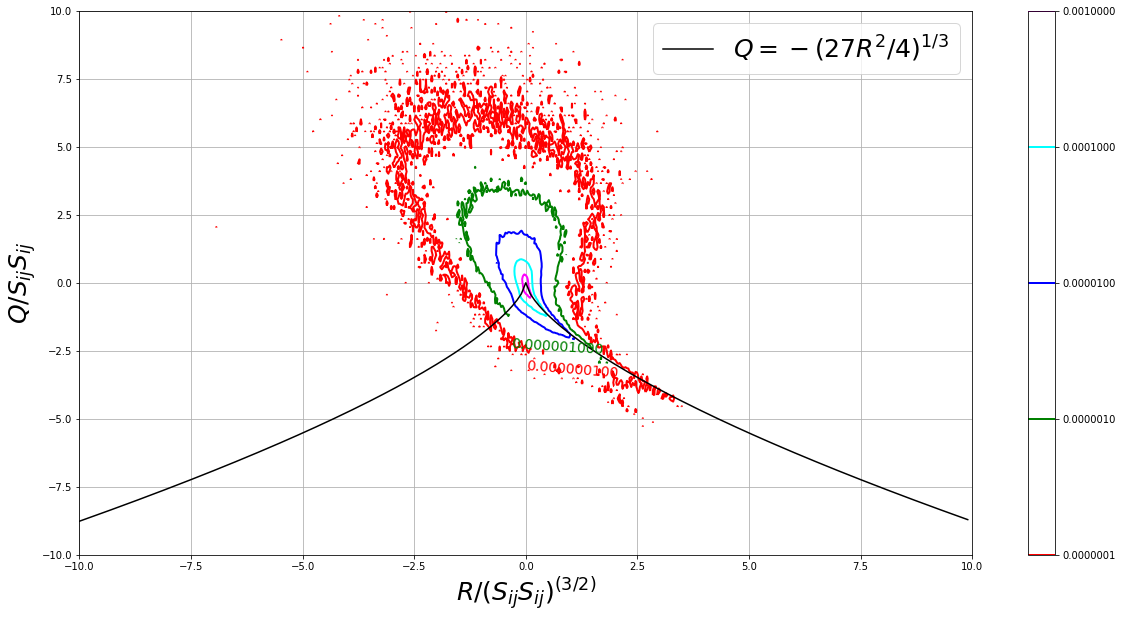

In [73]:
plot_Q_R(Q_f,R_f,SijSij_mean_f,binwidth=3)
